### **PINN code for Porous Media Permeability Upscaling - Predict L1**

#### Load Libraries

In [1]:
# General Libraries
from numpy import sqrt
from numpy import savetxt
import numpy as np
import pandas as pd
from pandas import read_csv
import os
# ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.utils import losses_utils
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from contextlib import redirect_stdout
# Visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

# Choose GPU to use (8 available) - skip 0 (busy)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[4:8], 'GPU')
tf.get_logger().setLevel('ERROR')

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

#### Load Data - Update

In [2]:
# Data filename
rock_type = "BrSS"
data_file = './data/'+rock_type+'_compiled_data_level_1'   
# Save Folder
mode = 'loss'                                                             #update, loss, lambda                   
formula = 'elmorsy'
trial = '_'+rock_type+'_level_1_'+formula+'_'+mode+'_1'                   #update
ana_sol = "hat_"+formula
#
if mode == 'loss':
    network = 'mlp_data_split_0.2_3_rocks_KF_elmorsy_8x4L_BEST'
if mode =='lambda':
    network = 'mlp_data_split_0.2_3_rocks_KF_elmorsy_Lambda_test_7_BEST'
#
save_name = './networks/predict/'+network+trial
# Load data files
data = pd.read_csv(data_file+".csv")
# List data heads
data.head()

,case-name,P,EP,KX,KY,KZ,c1,p1,ep1,kx1,...,ep7,kx7,ky7,kz7,c8,p8,ep8,kx8,ky8,kz8
0,1.0,0.192573,0.186276,1.4912,1.7233,1.6372,1,0.193009,0.191142,2.4460,...,0.163866,0.6920,1.5624,1.1966,3319,0.172737,0.167435,1.4183,0.6886,0.6095
1,3.0,0.193239,0.190980,1.6700,1.6086,2.0374,3,0.225935,0.222174,3.4934,...,0.160469,1.6715,1.3917,1.4990,3321,0.177349,0.170905,2.0760,0.8795,1.3581
2,5.0,0.202113,0.199161,1.6778,1.6855,2.0529,5,0.254325,0.252918,3.6061,...,0.147201,1.1211,0.7018,0.6843,3323,0.193674,0.185215,1.5141,2.4144,2.4521
3,13.0,0.214707,0.212279,2.1758,2.7908,2.8160,13,0.213592,0.212264,2.4450,...,0.184381,1.2211,1.9530,2.3633,3331,0.198052,0.194362,0.4687,0.4724,1.6870
4,15.0,0.211278,0.208762,2.0857,2.7348,2.4716,15,0.218395,0.216979,2.3116,...,0.210038,1.3492,2.7641,2.1338,3333,0.161127,0.155172,0.3144,0.4075,1.3504


#### Define Custome Functions

In [3]:
def get_XY(data):
    X = pd.DataFrame()
    for i in range(1, 9):
        kx = "kx"+str(i)
        ky = "ky"+str(i)
        kz = "kz"+str(i)
        X = pd.concat([X, data[kx], data[ky], data[kz]], axis=1)
    Y = data["KX"]  

    return X, Y

def data_rotate(data):
    data_len = len(data["KX"])
    # create extended data
    column_list = list(data)
    zero_data = np.zeros(shape=(len(data),len(column_list)))
    zero_data = pd.DataFrame(zero_data, columns=column_list)
    data_ext = pd.concat([data, zero_data, zero_data], ignore_index=True)
    # Rotate and combine data
    # large K dataset
    data_ext['KX'] = pd.concat([data['KX'], data['KY'], data['KZ']], ignore_index=True)
    # small k in X Directions
    data_ext['kx1'] = pd.concat([data['kx1'], data['ky1'], data['kz1']], ignore_index=True)
    data_ext['kx2'] = pd.concat([data['kx2'], data['ky5'], data['kz2']], ignore_index=True)
    data_ext['kx3'] = pd.concat([data['kx3'], data['ky3'], data['kz5']], ignore_index=True)
    data_ext['kx4'] = pd.concat([data['kx4'], data['ky7'], data['kz6']], ignore_index=True)
    data_ext['kx5'] = pd.concat([data['kx5'], data['ky2'], data['kz3']], ignore_index=True)
    data_ext['kx6'] = pd.concat([data['kx6'], data['ky6'], data['kz4']], ignore_index=True)
    data_ext['kx7'] = pd.concat([data['kx7'], data['ky4'], data['kz7']], ignore_index=True)
    data_ext['kx8'] = pd.concat([data['kx8'], data['ky8'], data['kz8']], ignore_index=True)
    # small k in Y Directions
    data_ext['ky1'] = pd.concat([data['ky1'], data['kx1'], data['ky1']], ignore_index=True)
    data_ext['ky2'] = pd.concat([data['ky2'], data['kx5'], data['ky2']], ignore_index=True)
    data_ext['ky3'] = pd.concat([data['ky3'], data['kx3'], data['ky5']], ignore_index=True)
    data_ext['ky4'] = pd.concat([data['ky4'], data['kx7'], data['ky6']], ignore_index=True)
    data_ext['ky5'] = pd.concat([data['ky5'], data['kx2'], data['ky3']], ignore_index=True)
    data_ext['ky6'] = pd.concat([data['ky6'], data['kx6'], data['ky4']], ignore_index=True)
    data_ext['ky7'] = pd.concat([data['ky7'], data['kx4'], data['ky7']], ignore_index=True)
    data_ext['ky8'] = pd.concat([data['ky8'], data['kx8'], data['ky8']], ignore_index=True)
    # small k in Z Directions
    data_ext['kz1'] = pd.concat([data['kz1'], data['kz1'], data['kx1']], ignore_index=True)
    data_ext['kz2'] = pd.concat([data['kz2'], data['kz5'], data['kx2']], ignore_index=True)
    data_ext['kz3'] = pd.concat([data['kz3'], data['kz3'], data['kx5']], ignore_index=True)
    data_ext['kz4'] = pd.concat([data['kz4'], data['kz7'], data['kx6']], ignore_index=True)
    data_ext['kz5'] = pd.concat([data['kz5'], data['kz2'], data['kx3']], ignore_index=True)
    data_ext['kz6'] = pd.concat([data['kz6'], data['kz6'], data['kx4']], ignore_index=True)
    data_ext['kz7'] = pd.concat([data['kz7'], data['kz4'], data['kx7']], ignore_index=True)
    data_ext['kz8'] = pd.concat([data['kz8'], data['kz8'], data['kx8']], ignore_index=True)
    # porosity
    data_ext['P'] = pd.concat([data['P'], data['P'], data['P']], ignore_index=True)
    data_ext['p1'] = pd.concat([data['p1'], data['p1'], data['p1']], ignore_index=True)
    data_ext['p2'] = pd.concat([data['p2'], data['p5'], data['p2']], ignore_index=True)
    data_ext['p3'] = pd.concat([data['p3'], data['p3'], data['p5']], ignore_index=True)
    data_ext['p4'] = pd.concat([data['p4'], data['p7'], data['p6']], ignore_index=True)
    data_ext['p5'] = pd.concat([data['p5'], data['p2'], data['p3']], ignore_index=True)
    data_ext['p6'] = pd.concat([data['p6'], data['p6'], data['p4']], ignore_index=True)
    data_ext['p7'] = pd.concat([data['p7'], data['p4'], data['p7']], ignore_index=True)
    data_ext['p8'] = pd.concat([data['p8'], data['p8'], data['p8']], ignore_index=True)
    # eff. porosity
    data_ext['EP'] = pd.concat([data['EP'], data['EP'], data['EP']], ignore_index=True)
    data_ext['ep1'] = pd.concat([data['ep1'], data['ep1'], data['ep1']], ignore_index=True)
    data_ext['ep2'] = pd.concat([data['ep2'], data['ep5'], data['ep2']], ignore_index=True)
    data_ext['ep3'] = pd.concat([data['ep3'], data['ep3'], data['ep5']], ignore_index=True)
    data_ext['ep4'] = pd.concat([data['ep4'], data['ep7'], data['ep6']], ignore_index=True)
    data_ext['ep5'] = pd.concat([data['ep5'], data['ep2'], data['ep3']], ignore_index=True)
    data_ext['ep6'] = pd.concat([data['ep6'], data['ep6'], data['ep4']], ignore_index=True)
    data_ext['ep7'] = pd.concat([data['ep7'], data['ep4'], data['ep7']], ignore_index=True)
    data_ext['ep8'] = pd.concat([data['ep8'], data['ep8'], data['ep8']], ignore_index=True)
    # case-name
    data_ext['case-name'] = pd.concat([data['case-name'], data['case-name'], data['case-name']], ignore_index=True)
    # add directions
    data_ext.rename(columns = {'KY':'direction'}, inplace = True)
    ones = pd.Series(np.ones(data_len))
    data_ext['direction'] = pd.concat([ones, ones*2, ones*3], ignore_index=True)
    # drop remaining features
    data_ext = data_ext.drop(columns=['KZ', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])
    
    return data_ext

def data_summary(hat, true, percentile):
    # calc error
    RE = (hat-true)/true
    ARE = RE.abs()    
    # Summarze data in one dataframe
    data_summary = pd.DataFrame(columns=['hat', 'true', 'ARE'], index=range(len(true)))
    data_summary['true'] = true.reset_index(drop=True)
    data_summary['hat'] = hat
    data_summary['ARE'] = ARE.reset_index(drop=True)    
    # 95 percintile of Testing data results
    data_summary = data_summary[(data_summary.ARE < ARE.quantile(percentile))]
    
    return data_summary
    
def print_results(MARE_ana, MARE, MedRE, ER):
    print('Testing MARE  (Analytical) [%] = '+str(round(MARE_ana*100, 1)))
    print('Testing MARE  (PINN)       [%] = '+str(round(MARE*100, 1)))
    print('Testing MedRE (PINN)       [%] = '+str(round(MedRE*100, 1)))
    print('MARE Reduction             [%] = '+str(round(ER*100, 1)))
    return

# Visualization
def hist(x, bins=30, color='lightgreen', alpha=1, xlabel='xlabel', title='title',
         stat=None, xlim=None, ylim=None, version=''):
    MARE = np.mean(abs(x))
    MedRE = np.median(abs(x))
    plt.hist(x, bins=bins, color=color, alpha=alpha, edgecolor='black', linewidth=0.7)
    
    plt.tick_params(direction="in", pad=5, labelsize=12)
    if ylim != None:
        plt.ylim(ylim[0],ylim[1])
    if xlim != None:
        plt.xlim(xlim[0],xlim[1])
    if stat == False:
        plt.title(title, size=12)
    else:
        MARE = np.mean(abs(x))
        MedRE = np.median(abs(x))
        plt.axvline(MARE, color='r', linestyle='dashed', linewidth=1)
        plt.axvline(MedRE, color='k', linestyle='dashed', linewidth=1)
        plt.legend(['Mean', 'Median'], loc='upper right')
        plt.title(title+'\n MARE= '+str(round(MARE, 2)), size=12)
        # plt.title(title, size=12)
    plt.ylabel('Number of samples [-]', size=12)
    plt.xlabel(xlabel, size=12)
    plt.savefig(color+version+'_hist.png', dpi=300)
    plt.savefig(color+version+'_hist.pdf', dpi=300)
    #plt.savefig('K_hist.eps', format='eps')
    plt.show()
    #plt.clf()
    return

In [4]:
# replace zeros
data_1 = data.replace(0, 0.000001)
# Rotate data
data_3dir = data_rotate(data_1)

#### Select Input and Target data points

In [5]:
X_test, Y_test = get_XY(data_3dir)
Y_test_true = Y_test

#### PINN Custome Functions

In [6]:
# Define Lambda Function - 3D
def keff_3d_aniso_tensor(tensor):
    # print(tensor)
    # k1
    kx1 = tensor[:, 0:1]
    ky1 = tensor[:, 1:2]
    kz1 = tensor[:, 2:3]
    # print(kx1)
    # k2
    kx2 = tensor[:, 3:4]
    ky2 = tensor[:, 4:5]
    kz2 = tensor[:, 5:6]
    # k3
    kx3 = tensor[:, 6:7]
    ky3 = tensor[:, 7:8]
    kz3 = tensor[:, 8:9]
    # k4
    kx4 = tensor[:, 9:10]
    ky4 = tensor[:, 10:11]
    kz4 = tensor[:, 11:12]
    # k5
    kx5 = tensor[:, 12:13]
    ky5 = tensor[:, 13:14]
    kz5 = tensor[:, 14:15]
    # k6
    kx6 = tensor[:, 15:16]
    ky6 = tensor[:, 16:17]
    kz6 = tensor[:, 17:18]
    # k7
    kx7 = tensor[:, 18:19]
    ky7 = tensor[:, 19:20]
    kz7 = tensor[:, 20:21]
    # k8
    kx8 = tensor[:, 21:22]
    ky8 = tensor[:, 22:23]
    kz8 = tensor[:, 23:24]

    def keff_2d_aniso(k1x, k2x, k3x, k4x, k1z, k2z, k3z, k4z):
     
        keff_2d = 1/(k1z*k3z/(2*(k1x*k1z*k3x + k1x*k1z*k3z + k1x*k3x*k3z + k1z*k3x*k3z)) + 
                k2z*k4z/(2*(k2x*k2z*k4x + k2x*k2z*k4z + k2x*k4x*k4z + k2z*k4x*k4z)) + 
                (k1x*(k1z + k3z)/(2*(k1x*k1z*k3x + k1x*k1z*k3z + k1x*k3x*k3z + k1z*k3x*k3z)) + 
                k2x*(k2z + k4z)/(2*(k2x*k2z*k4x + k2x*k2z*k4z + k2x*k4x*k4z + k2z*k4x*k4z)) + 
                1/(2*k4x) + 1/(2*k3x))*(k3x*(k1z + k3z)/(2*(k1x*k1z*k3x + k1x*k1z*k3z + k1x*k3x*k3z + k1z*k3x*k3z)) + 
                k4x*(k2z + k4z)/(2*(k2x*k2z*k4x + k2x*k2z*k4z + k2x*k4x*k4z + k2z*k4x*k4z)) + 
                1/(2*k2x) + 1/(2*k1x))/(k1x*(k1z + k3z)/(2*(k1x*k1z*k3x + k1x*k1z*k3z + k1x*k3x*k3z + k1z*k3x*k3z)) + 
                k2x*(k2z + k4z)/(2*(k2x*k2z*k4x + k2x*k2z*k4z + k2x*k4x*k4z + k2z*k4x*k4z)) + 
                k3x*(k1z + k3z)/(2*(k1x*k1z*k3x + k1x*k1z*k3z + k1x*k3x*k3z + k1z*k3x*k3z)) + 
                k4x*(k2z + k4z)/(2*(k2x*k2z*k4x + k2x*k2z*k4z + k2x*k4x*k4z + k2z*k4x*k4z)) + 
                1/(2*k4x) + 1/(2*k3x) + 1/(2*k2x) + 1/(2*k1x)))
        
        return keff_2d
    
    # Left face > casenames: 1-5-3-7 (kx, kz)
    k_2d_l = keff_2d_aniso(kx1, kx5, kx3, kx7, kz1, kz5, kz3, kz7)
    
    # Right face > casenames: 2-6-4-8 (kx, kz)
    k_2d_r = keff_2d_aniso(kx2, kx6, kx4, kx8, kz2, kz6, kz4, kz8)
    
    # Top face > casenames: 1-5-2-6 (kx, ky)
    k_2d_t = keff_2d_aniso(kx1, kx5, kx2, kx6, ky1, ky5, ky2, ky6)
    
    # Bottom face > casenames: 3-7-4-8 (kx, ky)
    k_2d_b = keff_2d_aniso(kx3, kx7, kx4, kx8, ky3, ky7, ky4, ky8)
    
    # Calculate Keff in 3D
    keff_3d = (k_2d_l + k_2d_r + k_2d_t + k_2d_b) / 4
    
    return keff_3d

In [7]:
# Define Lambda Functions - 2D
def keff_2d_aniso(k1x, k2x, k3x, k4x, k1z, k2z, k3z, k4z):
    
    keff_2d = 1/(k1z*k3z/(2*(k1x*k1z*k3x + k1x*k1z*k3z + k1x*k3x*k3z + k1z*k3x*k3z)) + 
            k2z*k4z/(2*(k2x*k2z*k4x + k2x*k2z*k4z + k2x*k4x*k4z + k2z*k4x*k4z)) + 
            (k1x*(k1z + k3z)/(2*(k1x*k1z*k3x + k1x*k1z*k3z + k1x*k3x*k3z + k1z*k3x*k3z)) + 
            k2x*(k2z + k4z)/(2*(k2x*k2z*k4x + k2x*k2z*k4z + k2x*k4x*k4z + k2z*k4x*k4z)) + 
            1/(2*k4x) + 1/(2*k3x))*(k3x*(k1z + k3z)/(2*(k1x*k1z*k3x + k1x*k1z*k3z + k1x*k3x*k3z + k1z*k3x*k3z)) + 
            k4x*(k2z + k4z)/(2*(k2x*k2z*k4x + k2x*k2z*k4z + k2x*k4x*k4z + k2z*k4x*k4z)) + 
            1/(2*k2x) + 1/(2*k1x))/(k1x*(k1z + k3z)/(2*(k1x*k1z*k3x + k1x*k1z*k3z + k1x*k3x*k3z + k1z*k3x*k3z)) + 
            k2x*(k2z + k4z)/(2*(k2x*k2z*k4x + k2x*k2z*k4z + k2x*k4x*k4z + k2z*k4x*k4z)) + 
            k3x*(k1z + k3z)/(2*(k1x*k1z*k3x + k1x*k1z*k3z + k1x*k3x*k3z + k1z*k3x*k3z)) + 
            k4x*(k2z + k4z)/(2*(k2x*k2z*k4x + k2x*k2z*k4z + k2x*k4x*k4z + k2z*k4x*k4z)) + 
            1/(2*k4x) + 1/(2*k3x) + 1/(2*k2x) + 1/(2*k1x)))
    
    return keff_2d

def keff_2d_aniso_tensor_l(tensor):
    # k1
    kx1 = tensor[:, 0:1]
    kz1 = tensor[:, 2:3]
    # k3
    kx3 = tensor[:, 6:7]
    kz3 = tensor[:, 8:9]
    # k5
    kx5 = tensor[:, 12:13]
    kz5 = tensor[:, 14:15]
    # k7
    kx7 = tensor[:, 18:19]
    kz7 = tensor[:, 20:21]
    
    # Left face > casenames: 1-5-3-7 (kx, kz)
    k_2d_l = keff_2d_aniso(kx1, kx5, kx3, kx7, kz1, kz5, kz3, kz7)
    
    return k_2d_l

def keff_2d_aniso_tensor_r(tensor):
    # k2
    kx2 = tensor[:, 3:4]
    kz2 = tensor[:, 5:6]
    # k4
    kx4 = tensor[:, 9:10]
    kz4 = tensor[:, 11:12]
    # k6
    kx6 = tensor[:, 15:16]
    kz6 = tensor[:, 17:18]
    # k8
    kx8 = tensor[:, 21:22]
    kz8 = tensor[:, 23:24]

    # Right face > casenames: 2-6-4-8 (kx, kz)
    k_2d_r = keff_2d_aniso(kx2, kx6, kx4, kx8, kz2, kz6, kz4, kz8)
    
    return k_2d_r

def keff_2d_aniso_tensor_t(tensor):
    # print(tensor)
    # k1
    kx1 = tensor[:, 0:1]
    ky1 = tensor[:, 1:2]
    # print(kx1)
    # k2
    kx2 = tensor[:, 3:4]
    ky2 = tensor[:, 4:5]
    # k5
    kx5 = tensor[:, 12:13]
    ky5 = tensor[:, 13:14]
    # k6
    kx6 = tensor[:, 15:16]
    ky6 = tensor[:, 16:17]
    
    # Top face > casenames: 1-5-2-6 (kx, ky)
    k_2d_t = keff_2d_aniso(kx1, kx5, kx2, kx6, ky1, ky5, ky2, ky6)

    return k_2d_t

def keff_2d_aniso_tensor_b(tensor):
    # k3
    kx3 = tensor[:, 6:7]
    ky3 = tensor[:, 7:8]
    # k4
    kx4 = tensor[:, 9:10]
    ky4 = tensor[:, 10:11]
    # k7
    kx7 = tensor[:, 18:19]
    ky7 = tensor[:, 19:20]
    # k8
    kx8 = tensor[:, 21:22]
    ky8 = tensor[:, 22:23]

    # Bottom face > casenames: 3-7-4-8 (kx, ky)
    k_2d_b = keff_2d_aniso(kx3, kx7, kx4, kx8, ky3, ky7, ky4, ky8)
    
    return k_2d_b


def keff_3d_aniso(kx1, kx2, kx3, kx4, kx5, kx6, kx7, kx8,
                  ky1, ky2, ky3, ky4, ky5, ky6, ky7, ky8,
                  kz1, kz2, kz3, kz4, kz5, kz6, kz7, kz8):
      
    # Left face > casenames: 1-5-3-7 (kx, kz)
    k_2d_l = keff_2d_aniso(kx1, kx5, kx3, kx7, kz1, kz5, kz3, kz7)
    
    # Right face > casenames: 2-6-4-8 (kx, kz)
    k_2d_r = keff_2d_aniso(kx2, kx6, kx4, kx8, kz2, kz6, kz4, kz8)
    
    # Top face > casenames: 1-5-2-6 (kx, ky)
    k_2d_t = keff_2d_aniso(kx1, kx5, kx2, kx6, ky1, ky5, ky2, ky6)
    
    # Bottom face > casenames: 3-7-4-8 (kx, ky)
    k_2d_b = keff_2d_aniso(kx3, kx7, kx4, kx8, ky3, ky7, ky4, ky8)
    
    # Calculate Keff in 3D
    keff_3d = (k_2d_l + k_2d_r + k_2d_t + k_2d_b) / 4
    
    return keff_3d

#### PINN Architectures

In [8]:
def init_model_loss():
    # Initialize a feedforward neural network
    n_features = X_test.shape[1]
    inputs = keras.Input(shape=(n_features))
    x = layers.Dense((8), activation='relu', name='1st_layer')(inputs)  # 'name=' is optional
    x = layers.Dense((8), activation='relu', name='2nd_layer')(x)
    x = layers.Dense((8), activation='relu', name='3nd_layer')(x)
    x = layers.Dense((8), activation='relu', name='4th_layer')(x)
    outputs = layers.Dense((1))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def init_model_lambda():
    # Initialize a feedforward neural network
    n_features = X_test.shape[1]
    inputs = keras.Input(shape=(n_features))
    x = layers.Dense((4), activation='relu', name='1st_layer')(inputs)  # 'name=' is optional
    x = layers.Dense((4), activation='relu', name='2nd_layer')(x)
    x = layers.Dense((4), activation='relu', name='3rd_layer')(x)
    x = layers.Dense((4), activation='relu', name='4th_layer')(x)
    #
    y0 = layers.Lambda(keff_3d_aniso_tensor, name="lambda_layer_3d")(inputs)
    y1 = layers.Lambda(keff_2d_aniso_tensor_l, name="lambda_layer_2d_l")(inputs)
    y2 = layers.Lambda(keff_2d_aniso_tensor_r, name="lambda_layer_2d_r")(inputs)
    y3 = layers.Lambda(keff_2d_aniso_tensor_t, name="lambda_layer_2d_t")(inputs)
    y4 = layers.Lambda(keff_2d_aniso_tensor_b, name="lambda_layer_2d_b")(inputs)
    #
    y = layers.concatenate([y0, y1, y2, y3, y4], axis=-1)
    #
    y = layers.Dense((4), activation='relu', name='2th_layer_lambda')(y)
    y = layers.Dense((4), activation='relu', name='3th_layer_lambda')(y)
    y = layers.Dense((4), activation='relu', name='4th_layer_lambda')(y)
    #
    x = layers.concatenate([x, y], axis=-1)
    #
    x = layers.Dense((4), activation='relu', name='1st_FCL_layer')(x)
    x = layers.Dense((4), activation='relu', name='2nd_FCL_layer')(x)
    #
    outputs = layers.Dense((1))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

### Model Configuration

In [9]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# Loss Function
loss = tf.keras.losses.MeanAbsolutePercentageError(
        reduction=losses_utils.ReductionV2.AUTO, name='mean_absolute_percentage_error')
acc_metric = tf.keras.metrics.MeanAbsolutePercentageError()

BATCH_SIZE = 16
# Using Multiple GPUs takes more time than using one GPU.
#
if mode == 'loss':
    model = init_model_loss()
if mode =='lambda':
    model = init_model_lambda()
#      
# Compile Model
model.compile(loss=loss, 
                optimizer=optimizer, 
                metrics=[acc_metric])

# Create Diectory
isExist = os.path.exists(save_name)
if not isExist:
     os.mkdir(save_name)

In [10]:
## load weights
checkpoint_filepath = './networks/'+network+'/checkpoint'
model.load_weights(checkpoint_filepath)

with open(save_name+'/model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

#### Make Predictions and Save Results

In [11]:
# Predictions - PINN 
Y_test_pinn = tf.squeeze(model.predict(X_test)).numpy()

In [12]:
# Predictions - Elmorsy
data_0 = data
data = data_3dir
Y_test_elmo = pd.Series(np.zeros(len(data['KX'])))
for i in range(0, len(data['KX'])):
    Y_test_elmo[i] = keff_3d_aniso(data['kx1'][i], data['kx2'][i], data['kx3'][i], data['kx4'][i], 
                                   data['kx5'][i], data['kx6'][i], data['kx7'][i], data['kx8'][i],
                             
                                   data['ky1'][i], data['ky2'][i], data['ky3'][i], data['ky4'][i], 
                                   data['ky5'][i], data['ky6'][i], data['ky7'][i], data['ky8'][i],
                             
                                   data['kz1'][i], data['kz2'][i], data['kz3'][i], data['kz4'][i], 
                                   data['kz5'][i], data['kz6'][i], data['kz7'][i], data['kz8'][i])

data = data_0
del data_0

In [13]:
# Converting 3 directions into 1 direction
data_3dir["KX_pinn"] = Y_test_pinn
data_3dir["KX_elmo"] = Y_test_elmo
data_hat = data_3dir[["case-name", "direction", "P", "EP", "KX", "KX_pinn", "KX_elmo"]]
#
#
data_hat_y = data_hat.loc[data_hat["direction"] == 2].reset_index()
data_hat_z = data_hat.loc[data_hat["direction"] == 3].reset_index()
data_hat = data_hat.loc[data_hat["direction"] == 1].reset_index()
#
data_hat[["KY_pinn", "KY_elmo", "case-name_2"]] = data_hat_y[["KX_pinn", "KX_elmo", "case-name"]]
data_hat[["KZ_pinn", "KZ_elmo", "case-name_3"]] = data_hat_z[["KX_pinn", "KX_elmo", "case-name"]]
#
d1 = np.sum(data_hat["case-name"] - data_hat["case-name_2"])
d2 = np.sum(data_hat["case-name"] - data_hat["case-name_3"])
d3 = np.sum(data_hat["case-name_2"] - data_hat["case-name_3"])
print("case-names sum check: "+ str(d1+d2+d3))
#
data_hat = data_hat.drop(columns=["direction", "case-name_2", "case-name_3"])

case-names sum check: 0.0


In [14]:
cols = ["case-name", "Porosity", "Eff. Porosity", "K(x)[D]", "K(y)[D]", "K(z)[D]", "M. time[s]", "S. Time[s]"]
numRows = data_hat.shape[0] 
data_kxyz_pinn = pd.DataFrame(columns=cols, index=range(numRows))
data_kxyz_elmo = pd.DataFrame(columns=cols, index=range(numRows))
#
data_kxyz_pinn[cols] = data_hat[["case-name", "P", "EP", "KX_pinn", "KY_pinn", "KZ_pinn", "case-name", "case-name"]]
data_kxyz_elmo[cols] = data_hat[["case-name", "P", "EP", "KX_elmo", "KY_elmo", "KZ_elmo", "case-name", "case-name"]]
#
# Save files
data_kxyz_pinn.to_csv(save_name+'/'+rock_type+'_300_kxyz_results_pinn_'+mode+'.csv', index=False)
data_kxyz_elmo.to_csv(save_name+'/'+rock_type+'_300_kxyz_results_analytical.csv', index=False)
data_hat.to_csv(save_name+'/'+rock_type+'_300_kxyz_results_hat.csv', index=False)

# Save files to predict folder
data_kxyz_pinn.to_csv('./sim_results_predicted/'+rock_type+'_300_kxyz_results_pinn_'+mode+'.csv', index=False)
data_kxyz_elmo.to_csv('./sim_results_predicted/'+rock_type+'_300_kxyz_results_analytical.csv', index=False)

In [15]:
# Store summary
data_summary_test = data_summary(Y_test_pinn*1000, Y_test*1000, 1)
# Save results
data_summary_test.to_csv(save_name+'/data_summary_test.csv', index=False)

In [16]:
# Stat
MARE_ana = np.mean(abs((Y_test_elmo-Y_test)/Y_test))
MARE = np.mean(data_summary_test["ARE"])
MedRE = np.median(abs(data_summary_test["ARE"]))
ER = (MARE_ana - MARE) / MARE_ana
# Print
print_results(MARE_ana, MARE, MedRE, ER)

with open(save_name+'/results_summary.txt', 'w') as f:
    with redirect_stdout(f):
        print_results(MARE_ana, MARE, MedRE, ER)

Testing MARE  (Analytical) [%] = 15.3
Testing MARE  (PINN)       [%] = 10.8
Testing MedRE (PINN)       [%] = 9.2
MARE Reduction             [%] = 29.8


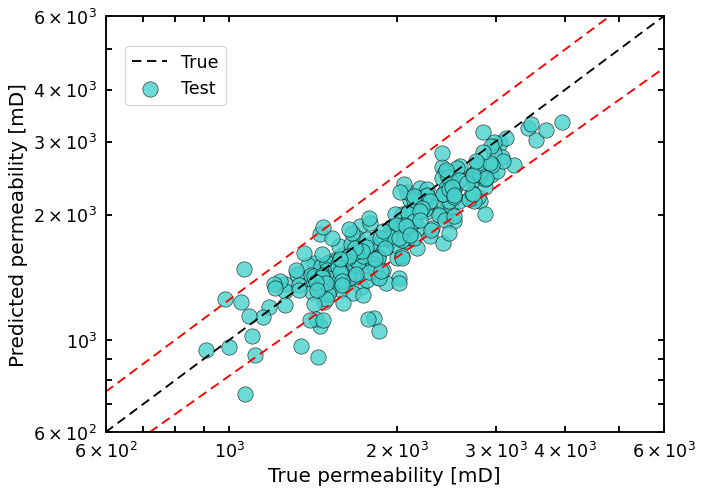

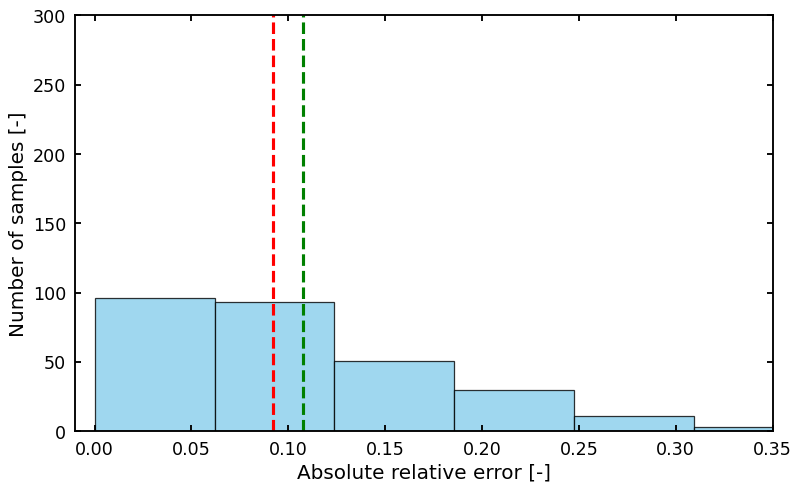

In [17]:
# LateX format for plots
# mpl.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})
mpl.rcParams.update(mpl.rcParamsDefault)

# set plot resoluton
plt.rcParams["figure.dpi"] = 120
plt.rcParams['axes.linewidth'] = 1.5
#
# Scatter plot Log scale Train and Test sets
#
font_size = 16
log_base = 10
max = 6000
min = 600
color = 'mediumturquoise' #'wheat'#'lightgreen' #'mediumturquoise'
# min = max/log_base
x1 = data_summary_test["true"]
y1 = data_summary_test["hat"]
#
plt.figure(figsize=(8, 6), dpi=90)
plt.plot([min, max], [min, max], color='k', linestyle='--', dashes=(5, 3), linewidth=1.5, alpha=1)
#
plt.scatter(x1, y1, c=color, s=150, alpha=0.8, edgecolors='k', linewidth=0.5)
#
plt.plot([min*1.2, max], [min, max*0.75], color='r', linestyle='--', dashes=(5, 3), linewidth=1.5, alpha=1, label='_nolegend_')
plt.plot([min, max*0.8], [min*1.25, max], color='r', linestyle='--', dashes=(5, 3), linewidth=1.5, alpha=1, label='_nolegend_')
#
plt.ylim([min, max])
plt.xlim([min, max])
#
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in", pad=7, length=5, width=1.5, labelsize=font_size-2, axis='both', which='both')
plt.loglog(base=log_base)
plt.legend(['True','Test'], loc='upper left',fontsize=font_size-2, bbox_to_anchor=(0.02, 0.95))
plt.ylabel('Predicted permeability [mD]', size=font_size)
plt.xlabel('True permeability [mD]', size=font_size)
plt.title("", size=font_size)
plt.savefig(save_name+'/predictions_tt_scatter_log.png', bbox_inches='tight', dpi=400)
plt.savefig(save_name+'/predictions_tt_scatter_log.pdf', bbox_inches='tight', dpi=400)
plt.show()
# plt.clf()
## Plot histograms
x = data_summary_test['ARE']
color = 'skyblue'
bins = 7
plt.figure(figsize=(10, 6), dpi=90)
plt.hist(x, bins=bins, color=color, alpha= 0.8, edgecolor='black', linewidth=1)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in", pad=7, length=5, width=1.5, labelsize=font_size-2)
plt.ylim(-0.01, 300)
plt.xlim(-0.01, 0.35)
MARE = np.mean(abs(x))
MedRE = np.median(abs(x))
plt.axvline(MARE, color='g', linestyle='dashed', linewidth=2.5)
plt.axvline(MedRE, color='r', linestyle='dashed', linewidth=2.5)
plt.ylabel('Number of samples [-]', size=font_size)
plt.xlabel('Absolute relative error [-]', size=font_size)
plt.savefig(save_name+'/ARE_hist.png', bbox_inches='tight', dpi=400)
plt.savefig(save_name+'/ARE_hist.pdf', bbox_inches='tight', dpi=400)
#plt.savefig('K_hist.eps', format='eps')
plt.show()
#plt.clf()